## EDA on metadata

### I. Introduction

The purpose of this notebook is to understand the format of the podcast by doing some exploratory data analysis on the metadata we extracted and cleaned in notebook I. and II. respectively.
The EDA on the text will be done on notebook IV. 

In [1]:
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from time import sleep
from random import randint
from datetime import datetime, timedelta
import matplotlib as plt
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('jredataclean')
df=df.drop(['Unnamed: 0'], axis=1)
df.head()

,date,guest,duration
0,2020-06-03,Krystal & Saagar,NaN
1,2020-06-02,Reggie Watts,2:46:32
2,2020-05-29,Jesus Trejo,2:52:47
3,2020-05-28,Jordan Jonas,2:22:39
4,2020-05-27,wittman/JRE MMA Show with Justin Gaethje &amp...,2:58:39


In [3]:
df.shape

(1608, 3)

In [4]:
df.dropna(subset=['duration'], inplace=True)

In [5]:
df.shape

(1498, 3)

### II. Understand the scale of the podcast
How many hours does the podcast represent?

In [6]:
dfindex=df.set_index('guest')
dfindex

,date,duration
guest,,
Reggie Watts,2020-06-02,2:46:32
Jesus Trejo,2020-05-29,2:52:47
Jordan Jonas,2020-05-28,2:22:39
wittman/JRE MMA Show with Justin Gaethje &amp; Trevor Wittman,2020-05-27,2:58:39
Adam Eget,2020-05-26,2:50:01
...,...,...
Brian Redban,2010-02-03,2:32:24
Brian Redban,2010-01-28,2:33:55
Brian Redban,2010-01-13,2:18:25


In [7]:
totalSecs = 0
for tm in df['duration']:
    timeParts = [int(s) for s in tm.split(':')]
    totalSecs += (timeParts[0] * 60 + timeParts[1]) * 60 + timeParts[2]
totalSecs, sec = divmod(totalSecs, 60)
hr, min = divmod(totalSecs, 60)
print( "%d:%02d:%02d" % (hr, min, sec))

3954:51:20


The podcast have produced 4098 hours and 18 minutes of content...  
...or 164 days and 19 hours of non stop podcast.  
It would be impossible to understand what the podcast is about efficiently if we had to listen to it

### III. Understand the structure behind the invitees list
It seems that some guests are invited twice or more: how does the invitation to the podcast is structured? Is the podcast relying on recurrent guests or on unique apparition?

In [8]:
vc = df['guest'].value_counts().rename_axis('unique_values').reset_index(name='counts')
vc.head()

,unique_values,counts
0,Brian Redban,34
1,Bryan Callen,21
2,Duncan Trussell,19
3,Greg Fitzsimmons,17
4,"Ari Shaffir, Brian Redban",16


In [9]:
repartition = vc['counts'].value_counts().rename_axis('Number of podcast done').reset_index(name='invitee')
repartition.head(20)

,Number of podcast done,invitee
0,1,667
1,2,121
2,3,43
3,4,11
4,5,11
5,6,7
6,7,5
7,9,4
8,12,3
9,8,2


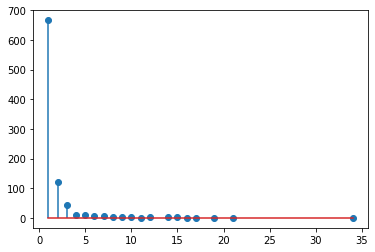

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = repartition['Number of podcast done']
y = repartition['invitee']

plt.stem(x, y, use_line_collection=True)
plt.show()

This graph is not really straightforward: we can see that the guests structure split itself between unique guests and recurrent guests, but it is hard to appreciat the scale of it. Let's try another system:   
> Guests participating only once to the podcast can be labelled "One Time Participant"  

> Guests participating between 2 and 9 times to the podcast can be labelled "Regular Invitee" 

> Guests participating 10 times or more can be labelled "Super Guest"  


In [11]:
vcindex=vc.set_index('unique_values')
vcindex.head()

,counts
unique_values,
Brian Redban,34
Bryan Callen,21
Duncan Trussell,19
Greg Fitzsimmons,17
"Ari Shaffir, Brian Redban",16


In [12]:
repartition['hosting type'] = np.where(repartition['Number of podcast done']<2, 'One Time Participant', repartition['Number of podcast done'])
repartition['hosting type'] = np.where(repartition['Number of podcast done']>1, 'Regular Invitee', repartition['hosting type'])
repartition['hosting type'] = np.where(repartition['Number of podcast done']>=10, 'Super Guest', repartition['hosting type'])
repartition['number of podacst by hosting type']=repartition['Number of podcast done']*repartition['invitee']
repartition

,Number of podcast done,invitee,hosting type,number of podacst by hosting type
0,1,667,One Time Participant,667
1,2,121,Regular Invitee,242
2,3,43,Regular Invitee,129
3,4,11,Regular Invitee,44
4,5,11,Regular Invitee,55
5,6,7,Regular Invitee,42
6,7,5,Regular Invitee,35
7,9,4,Regular Invitee,36
8,12,3,Super Guest,36
9,8,2,Regular Invitee,16


In [13]:
groupby_hosttype=repartition.groupby('hosting type').sum()
groupby_hosttype.drop(columns=['Number of podcast done'],inplace=True)
groupby_hosttype['invitee %']=groupby_hosttype['invitee']/(667+204+15)*100
groupby_hosttype['podacst %']=groupby_hosttype['number of podacst by hosting type']/(667+599+232)*100
groupby_hosttype

,invitee,number of podacst by hosting type,invitee %,podacst %
hosting type,,,,
One Time Participant,667,667,75.282167,44.526035
Regular Invitee,204,599,23.024831,39.986649
Super Guest,15,232,1.693002,15.487316


Let's try and visualize this information

In [14]:
import matplotlib.patches as mpatches # needed for waffle Charts
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (groupby_hosttype.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Total number of tiles is 868
One Time Participant: 653
Regular Invitee: 200
Super Guest: 15


<Figure size 432x288 with 0 Axes>

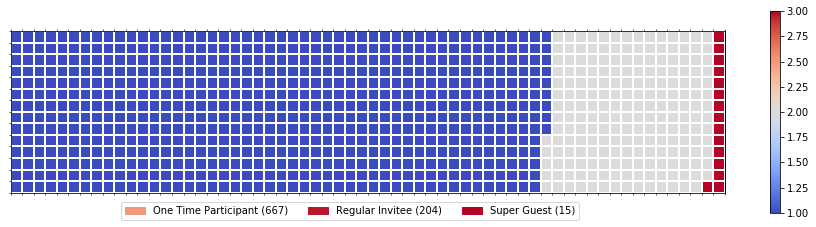

In [30]:
#Now just need to define input parameters
width = 62 # width of chart
height = 14 # height of chart

categories = groupby_hosttype.index.values # categories
values = groupby_hosttype['invitee'] # correponding values of categories

colormap = plt.cm.gist_earth # color map class
create_waffle_chart(categories, values, height, width, colormap)

Total number of tiles is 840
One Time Participant: 374
Regular Invitee: 336
Super Guest: 130


<Figure size 432x288 with 0 Axes>

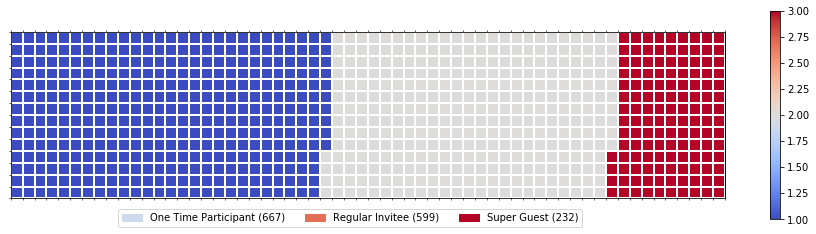

In [28]:
#Now just need to define input parameters
width = 60 # width of chart
height = 14 # height of chart

categories = groupby_hosttype.index.values # categories
values = groupby_hosttype['number of podacst by hosting type'] # correponding values of categories

colormap = plt.cm.gist_earth # color map class
create_waffle_chart(categories, values, height, width, colormap)

We can see that a minority of guests produce the majority of the content

### IV. Understand how attendance change over time
The podcast has been produced since 2009. Let's try and see how the guest structure has changed over the year.

In [67]:
df=df.merge(vc, left_on='guest', right_on='unique_values')
df.head()

,date,guest,duration,counts_x,Attendees type,year,One Time Participant,Regular Invitee,Super Guest,total,timestamp,unique_values,counts_y
0,2020-06-02,Reggie Watts,2:46:32,3,Regular Invitee,2020,0,1,0,1,2020-06-06 02:46:32,Reggie Watts,3
1,2019-07-09,Reggie Watts,2:33:50,3,Regular Invitee,2019,0,1,0,1,2020-06-06 02:33:50,Reggie Watts,3
2,2017-09-26,Reggie Watts,3:15:07,3,Regular Invitee,2017,0,1,0,1,2020-06-06 03:15:07,Reggie Watts,3
3,2020-05-29,Jesus Trejo,2:52:47,1,One Time Participant,2020,1,0,0,1,2020-06-06 02:52:47,Jesus Trejo,1
4,2020-05-28,Jordan Jonas,2:22:39,1,One Time Participant,2020,1,0,0,1,2020-06-06 02:22:39,Jordan Jonas,1


In [38]:
df['Attendees type'] = np.where(df['counts']<2, 'One Time Participant', df['counts'])
df['Attendees type'] = np.where(df['counts']>1, 'Regular Invitee', df['Attendees type'])
df['Attendees type'] = np.where(df['counts']>=10, 'Super Guest', df['Attendees type'])
df

,date,guest,duration,counts,Attendees type
0,2020-06-02,Reggie Watts,2:46:32,3,Regular Invitee
1,2019-07-09,Reggie Watts,2:33:50,3,Regular Invitee
2,2017-09-26,Reggie Watts,3:15:07,3,Regular Invitee
3,2020-05-29,Jesus Trejo,2:52:47,1,One Time Participant
4,2020-05-28,Jordan Jonas,2:22:39,1,One Time Participant
...,...,...,...,...,...
1493,2010-08-24,"RICKY SCHRODER, BRIAN REDBAN",2:02:06,1,One Time Participant
1494,2010-08-04,"Dane Cook, Brian Redban",2:29:13,1,One Time Participant
1495,2010-07-20,"Mayhem Miller, Brian Redban",2:11:04,1,One Time Participant
1496,2010-04-21,"Ari Shaffir, Eddie Bravo",2:10:41,1,One Time Participant


In [39]:
df['year'] = pd.DatetimeIndex(df['date']).year
df

,date,guest,duration,counts,Attendees type,year
0,2020-06-02,Reggie Watts,2:46:32,3,Regular Invitee,2020
1,2019-07-09,Reggie Watts,2:33:50,3,Regular Invitee,2019
2,2017-09-26,Reggie Watts,3:15:07,3,Regular Invitee,2017
3,2020-05-29,Jesus Trejo,2:52:47,1,One Time Participant,2020
4,2020-05-28,Jordan Jonas,2:22:39,1,One Time Participant,2020
...,...,...,...,...,...,...
1493,2010-08-24,"RICKY SCHRODER, BRIAN REDBAN",2:02:06,1,One Time Participant,2010
1494,2010-08-04,"Dane Cook, Brian Redban",2:29:13,1,One Time Participant,2010
1495,2010-07-20,"Mayhem Miller, Brian Redban",2:11:04,1,One Time Participant,2010
1496,2010-04-21,"Ari Shaffir, Eddie Bravo",2:10:41,1,One Time Participant,2010


In [40]:
groupby_year_and_type= df.groupby(['year','Attendees type']).size().to_frame()
groupby_year_and_type

0
year Attendees type           
2009 Super Guest             1
2010 One Time Participant   20
     Regular Invitee        12
     Super Guest            20
2011 One Time Participant   34
     Regular Invitee        39
     Super Guest            28
2012 One Time Participant   68
     Regular Invitee        31
     Super Guest            25
2013 One Time Participant   58
     Regular Invitee        43
     Super Guest            23
2014 One Time Participant   61
     Regular Invitee        75
     Super Guest            15
2015 One Time Participant   54
     Regular Invitee        69
     Super Guest            22
2016 One Time Participant   51
     Regular Invitee        62
     Super Guest            27
2017 One Time Participant   67
     Regular Invitee        90
     Super Guest            12
2018 One Time Participant  104
     Regular Invitee        66
     Super Guest            26
2019 One Time Participant  111
     Regular Invitee        77
     Super Guest            18
2020 One Time Participant   39
     Regular Invitee        35
     Super Guest            15

In [41]:
df['One Time Participant']= np.where(df['Attendees type']=='One Time Participant',1,0)
df['Regular Invitee']= np.where(df['Attendees type']=='Regular Invitee',1,0)
df['Super Guest']= np.where(df['Attendees type']=='Super Guest',1,0)
df['total']= df['One Time Participant']+df['Regular Invitee']+df['Super Guest']

df

,date,guest,duration,counts,Attendees type,year,One Time Participant,Regular Invitee,Super Guest,total
0,2020-06-02,Reggie Watts,2:46:32,3,Regular Invitee,2020,0,1,0,1
1,2019-07-09,Reggie Watts,2:33:50,3,Regular Invitee,2019,0,1,0,1
2,2017-09-26,Reggie Watts,3:15:07,3,Regular Invitee,2017,0,1,0,1
3,2020-05-29,Jesus Trejo,2:52:47,1,One Time Participant,2020,1,0,0,1
4,2020-05-28,Jordan Jonas,2:22:39,1,One Time Participant,2020,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1493,2010-08-24,"RICKY SCHRODER, BRIAN REDBAN",2:02:06,1,One Time Participant,2010,1,0,0,1
1494,2010-08-04,"Dane Cook, Brian Redban",2:29:13,1,One Time Participant,2010,1,0,0,1
1495,2010-07-20,"Mayhem Miller, Brian Redban",2:11:04,1,One Time Participant,2010,1,0,0,1
1496,2010-04-21,"Ari Shaffir, Eddie Bravo",2:10:41,1,One Time Participant,2010,1,0,0,1


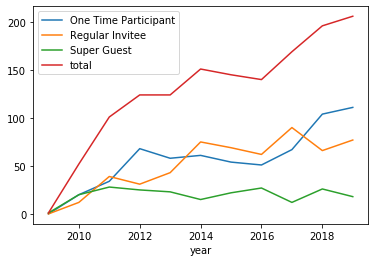

In [42]:
groupbyyear=df.groupby('year').sum().drop(['counts'], axis=1).drop([2020])
groupbyyear.plot()

### V. Understand the duration of the podcast
The podcast seems to have a 2 hours + runtime. Let's see how it breaks down

In [43]:
df

,date,guest,duration,counts,Attendees type,year,One Time Participant,Regular Invitee,Super Guest,total
0,2020-06-02,Reggie Watts,2:46:32,3,Regular Invitee,2020,0,1,0,1
1,2019-07-09,Reggie Watts,2:33:50,3,Regular Invitee,2019,0,1,0,1
2,2017-09-26,Reggie Watts,3:15:07,3,Regular Invitee,2017,0,1,0,1
3,2020-05-29,Jesus Trejo,2:52:47,1,One Time Participant,2020,1,0,0,1
4,2020-05-28,Jordan Jonas,2:22:39,1,One Time Participant,2020,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1493,2010-08-24,"RICKY SCHRODER, BRIAN REDBAN",2:02:06,1,One Time Participant,2010,1,0,0,1
1494,2010-08-04,"Dane Cook, Brian Redban",2:29:13,1,One Time Participant,2010,1,0,0,1
1495,2010-07-20,"Mayhem Miller, Brian Redban",2:11:04,1,One Time Participant,2010,1,0,0,1
1496,2010-04-21,"Ari Shaffir, Eddie Bravo",2:10:41,1,One Time Participant,2010,1,0,0,1


In [44]:
df['timestamp'] = pd.to_datetime(df['duration'])

print(df['timestamp'].mean().time())
print(df['timestamp'].max().time())
print(df['timestamp'].min().time())
df

02:38:24.325766
04:48:57
00:42:27


,date,guest,duration,counts,Attendees type,year,One Time Participant,Regular Invitee,Super Guest,total,timestamp
0,2020-06-02,Reggie Watts,2:46:32,3,Regular Invitee,2020,0,1,0,1,2020-06-06 02:46:32
1,2019-07-09,Reggie Watts,2:33:50,3,Regular Invitee,2019,0,1,0,1,2020-06-06 02:33:50
2,2017-09-26,Reggie Watts,3:15:07,3,Regular Invitee,2017,0,1,0,1,2020-06-06 03:15:07
3,2020-05-29,Jesus Trejo,2:52:47,1,One Time Participant,2020,1,0,0,1,2020-06-06 02:52:47
4,2020-05-28,Jordan Jonas,2:22:39,1,One Time Participant,2020,1,0,0,1,2020-06-06 02:22:39
...,...,...,...,...,...,...,...,...,...,...,...
1493,2010-08-24,"RICKY SCHRODER, BRIAN REDBAN",2:02:06,1,One Time Participant,2010,1,0,0,1,2020-06-06 02:02:06
1494,2010-08-04,"Dane Cook, Brian Redban",2:29:13,1,One Time Participant,2010,1,0,0,1,2020-06-06 02:29:13
1495,2010-07-20,"Mayhem Miller, Brian Redban",2:11:04,1,One Time Participant,2010,1,0,0,1,2020-06-06 02:11:04
1496,2010-04-21,"Ari Shaffir, Eddie Bravo",2:10:41,1,One Time Participant,2010,1,0,0,1,2020-06-06 02:10:41


We can see that the average runtime is 2 hours 38 minutes, but with outlier bearing extreme value (25 to 182 for a base 100). Let's try to see if the date or types of invitees plays a part in the very short or very long podcast.

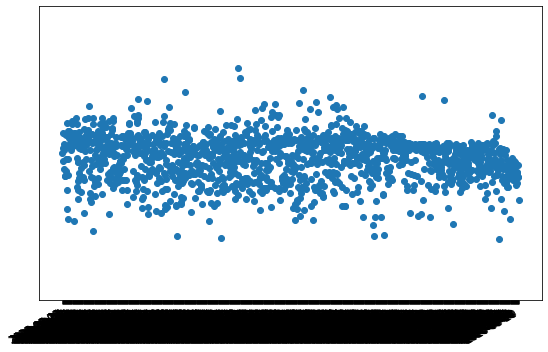

In [46]:
import datetime

x = df['date']
y = df['timestamp']

plt.figure(figsize=(9,6))

plt.yticks(np.arange(5,5.5, 0.25)) 

plt.scatter(x,y)
plt.gcf().autofmt_xdate()

plt.show()

The repartition of outlier over time seems consistent. The dates do seem to impact the runtime.

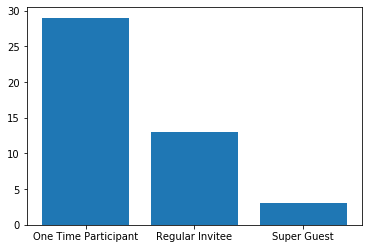

In [47]:
#let's take a look at the outlier from a guest type perspective
shortpodcast=df.sort_values(by='duration', ascending=True).head(45).groupby('Attendees type').size().to_frame()
shortpodcast.rename(columns={ shortpodcast.columns[0]: "occurence" }, inplace = True)
shortpodcast.reset_index(inplace=True)
plt.bar(shortpodcast['Attendees type'], shortpodcast['occurence'])
plt.xticks(shortpodcast['Attendees type'])
plt.show()

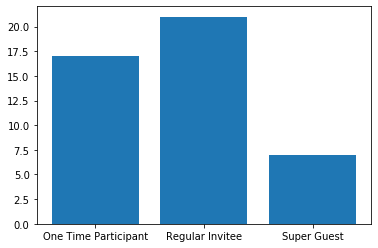

In [48]:
longpodcast=df.sort_values(by='duration', ascending=False).head(45).groupby('Attendees type').size().to_frame()
longpodcast.rename(columns={ longpodcast.columns[0]: "occurence" }, inplace = True)
longpodcast.reset_index(inplace = True)
plt.bar(longpodcast['Attendees type'], longpodcast['occurence'])
plt.xticks(longpodcast['Attendees type'])
plt.show()

In [66]:
df.to_csv('jredataeda.csv')